In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
from itertools import product
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
import netCDF4 as nc
from scipy.ndimage import zoom

npyPath = "skogsstyrelsen-data"
ncPath = "skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria"



## Band Descriptions:

### B1 (Coastal/Aerosol):
- **Wavelength**: 0.433 - 0.453 µm
- **Description**: Useful for coastal and aerosol studies, water body analysis, and distinguishing between land and water.

### B2 (Blue):
- **Wavelength**: 0.450 - 0.515 µm
- **Description**: Captures blue light, useful for water body analysis, soil/vegetation differentiation, and forest type mapping.

### B3 (Green):
- **Wavelength**: 0.525 - 0.600 µm
- **Description**: Captures green light, useful for assessing plant vigor and health.

### B4 (Red):
- **Wavelength**: 0.630 - 0.680 µm
- **Description**: Captures red light, useful for vegetation discrimination and soil/vegetation contrast.

### B5 (Near Infrared - NIR):
- **Wavelength**: 0.845 - 0.885 µm
- **Description**: Captures near-infrared light, useful for vegetation analysis, biomass estimation, and water body delineation.

### B6 (Shortwave Infrared 1 - SWIR1):
- **Wavelength**: 1.560 - 1.660 µm
- **Description**: Useful for soil moisture content, vegetation moisture, and distinguishing between clouds, snow, and ice.

### B7 (Shortwave Infrared 2 - SWIR2):
- **Wavelength**: 2.100 - 2.300 µm
- **Description**: Useful for similar purposes as SWIR1, including vegetation moisture and distinguishing between different types of land cover.

### B8 (Panchromatic):
- **Wavelength**: 0.500 - 0.680 µm
- **Description**: Captures a broad range of visible light, useful for high-resolution imagery and sharpening multispectral images.

### B9 (Cirrus):
- **Wavelength**: 1.360 - 1.390 µm
- **Description**: Useful for detecting cirrus clouds and atmospheric correction.

### B10 (Thermal Infrared 1 - TIR1):
- **Wavelength**: 10.60 - 11.19 µm
- **Description**: Captures thermal infrared radiation, useful for surface temperature mapping and thermal analysis.

### B11 (Thermal Infrared 2 - TIR2):
- **Wavelength**: 11.50 - 12.51 µm
- **Description**: Similar to TIR1, useful for surface temperature mapping and thermal analysis.

### B12 (Shortwave Infrared 3 - SWIR3):
- **Wavelength**: 1.640 - 1.670 µm
- **Description**: Useful for snow and ice detection, soil moisture, and distinguishing between clouds and snow.



In [10]:
def npy_loader(file_name):
    

    # Initialize data_list outside the loop
    data_list = []

    # Load and print contents of each file
    
    full_path = os.path.join(npyPath, file_name)  # Include folder path
    if os.path.exists(full_path):  # Ensure file exists
        data = np.load(full_path, allow_pickle=True)  # Load the .npy file
        # Extract 'ValideringsobjektBildId' and 'MolnDis' from each JSON line
        if isinstance(data, np.ndarray) and data.size > 0 and isinstance(data[0], dict):
            for item in data:
               # print(item)
                valideringsobjekt_bild_id = item.get('ValideringsobjektBildId', 'N/A')
                moln_dis = item.get('MolnDis', 'N/A')
                # Add to a list of lists
                data_list.append([valideringsobjekt_bild_id, moln_dis])
                
        else:
            print(f"File {file_name} does not contain the expected JSON data.")
    else:
        print(f"File {file_name} does not exist.")

    return data_list


    

## Cloud Detection Composite:
A Cloud Detection Composite typically combines bands that are sensitive to cloud properties and can differentiate clouds from other features. A good combination for cloud detection is:

- **B2 (Blue)**
- **B3 (Green)**
- **B11 (SWIR1)**
- **B12 (SWIR2)**

This combination leverages the visible and shortwave infrared bands to highlight clouds and differentiate them from other features like snow, ice, and land.

In [11]:

def combine_bands(data_list):
    """
    Combines selected spectral bands from netCDF files, resamples them to a fixed size, 
    normalizes them, and returns structured feature and label arrays.
    
    Parameters:
        data_list (list): List of tuples (file_id, label) for netCDF files.
        ncPath (str): Path to the directory containing netCDF files.

    Returns:
        np.array: Feature array of shape (num_samples, 21, 21, num_bands).
        np.array: Corresponding labels.
    """
    bands = ['b02', 'b03', 'b04','b11']  # Define bands to use
    target_shape = (21, 21)  # Fixed shape for resampling

    features = []
    labels = []

    for item in data_list:
        file_id, label = item
        file_path = os.path.join(ncPath, f'skgs_{file_id}.nc')

        try:
            # Open netCDF file
            with nc.Dataset(file_path, 'r') as dataset:
                resampled_bands = []
                

                #print(dataset)
                for band in bands:
                    if band in dataset.variables:
                        band_data = dataset.variables[band][0, :, :]  # Use first time slice
                        
                        # Handle NaN values
                        band_data = np.nan_to_num(band_data, nan=0.0)
                        
                        # Resample band
                        #band_resampled = resample_band(band_data, target_shape)
                        
                        # Normalize band
                        #band_normalized = min_max_normalize(band_resampled)
                        
                        resampled_bands.append(band_normalized)
                    else:
                        print(f"Warning: {band} not found in {file_path}")
                        resampled_bands.append(np.zeros(target_shape))  # Default empty band

                # Stack bands along the channel dimension (H, W, num_bands)
                combined_bands = np.stack(resampled_bands, axis=-1)
                
                # Append processed data
                features.append(combined_bands)
                labels.append(label)
                

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    # Graph the first image in the features array
    first_image = features[0]

    # Plot the combined bands as subplots with different colors for each band
    colors = ['Blues', 'Greens', 'Reds', 'Purples']  # Define color maps for each band
    fig, axes = plt.subplots(1, combined_bands.shape[-1], figsize=(15, 5))
    for i in range(combined_bands.shape[-1]):
        ax = axes[i]
        ax.imshow(combined_bands[:, :, i], cmap=colors[i])
        ax.set_title(f'Band {i+1}')
        ax.axis('off')

    plt.show()
    
    return np.array(features), np.array(labels)
    
    

# def resample_band(band_data, target_shape):
#     """Resample a 2D array using bilinear interpolation."""
#     zoom_factors = (target_shape[0] / band_data.shape[0], target_shape[1] / band_data.shape[1])
#     return zoom(band_data, zoom_factors, order=1)

# def min_max_normalize(data):
#     """Normalize data between 0 and 1."""
#     return (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-8)



In [12]:

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        # Ensure labels are integers (0 for not cloudy, 1 for cloudy)
        self.features = features
        self.labels = np.array(labels, dtype=np.int64)  # Make sure labels are integers

    def __len__(self):
        return len(self.features)

    def __getitem__(self):
        return self.features, self.labels

# Load and process dataset
train_features, train_labels = combine_bands(npy_loader('skogs_json_train.npy'))
val_features, val_labels = combine_bands(npy_loader('skogs_json_val.npy'))
test_features, test_labels = combine_bands(npy_loader('skogs_json_test.npy'))


#transforms
###
# 
# 
# 
# 

# Initialize datasets
train_dataset = CustomDataset(train_features, train_labels)
val_dataset = CustomDataset(val_features, val_labels)
test_dataset = CustomDataset(test_features, test_labels)


# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of testing samples:", len(test_dataset))

# Get a sample from the training dataset
sample_features, sample_label = train_dataset[0]
# Plot an RGB-like composite using all bands (B2, B3, B11, B12)





Error processing skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria\skgs_db7d323a-3fc7-ed11-9174-005056a6f472.nc: name 'band_normalized' is not defined
Error processing skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria\skgs_c4ade691-44c7-ed11-9174-005056a6f472.nc: name 'band_normalized' is not defined
Error processing skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria\skgs_4265b290-3ac7-ed11-9174-005056a6f472.nc: name 'band_normalized' is not defined
Error processing skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria\skgs_dbd95f27-3ac7-ed11-9174-005056a6f472.nc: name 'band_normalized' is not defined
Error processing skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria\skgs_fcdb2f62-43c7-ed11-9174-005056a6f472.nc: name 'band_normalized' is not defined
Error processing skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria\skgs_cde9b181-37c7-ed11-9174-005056a6f472.nc: name 'band_normalized' is not defined
Error processing skogsstyrelsen-data/2A-netcdfs-cropped-from-nuria\skgs_210bf8a8-45c7-ed11-917

IndexError: list index out of range

# ANN

# Neural Network Architecture Table

| **Layer**               | **Code**                                  | **Function** |
|-------------------------|------------------------------------------|-------------|
| **Flatten Layer**       | `nn.Flatten()`                           | Converts a `(4, 21, 21)` input into a `1D` vector of size `1764`. |
| **Fully Connected (FC1)** | `nn.Linear(4 * 21 * 21, hidden_size)`    | Maps `1764` input features to `hidden_size` (512 or 1024). |
| **ReLU Activation**     | `nn.ReLU()`                              | Introduces non-linearity to the network. |
| **Fully Connected (FC2)** | `nn.Linear(hidden_size, hidden_size // 2)` | Reduces features from `hidden_size` to half (`512 → 256`). |
| **ReLU Activation**     | `nn.ReLU()`                              | Introduces non-linearity. |
| **Fully Connected (FC3)** | `nn.Linear(hidden_size // 2, 128)`       | Further reduces features from `256 → 128`. |
| **ReLU Activation**     | `nn.ReLU()`                              | Introduces non-linearity. |
| **Dropout Layer**       | `nn.Dropout(dropout_rate)`               | Regularization technique to prevent overfitting (dropout rate: `0.3, 0.5, 0.7`). |
| **Output Layer**        | `nn.Linear(128, 2)`                      | Final classification layer for binary classification (2 classes). |




In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import copy
# import matplotlib.pyplot as plt
# from itertools import product

# # Define hyperparameter search space
# hyperparameter_grid = {
#     "learning_rate": [1e-3, 5e-4, 1e-4],  # Test different learning rates
#     "dropout_rate": [0.3, 0.5, 0.7],  # Different dropout probabilities
#     "hidden_layer_size": [512, 1024],  # Test different hidden layer sizes
# }

# # Get all hyperparameter combinations
# hyperparameter_combinations = list(product(*hyperparameter_grid.values()))

# # Track the best configuration
# best_hyperparams = None
# best_accuracy = 0.0
# best_model = None

# # Loop through each hyperparameter combination
# for lr, dropout_rate, hidden_size in hyperparameter_combinations:

#     # Define the model
#     network = nn.Sequential(
#         nn.Flatten(),  # Flatten the (4, 21, 21) input
#         nn.Linear(4 * 21 * 21, hidden_size),
#         nn.ReLU(),
#         nn.Linear(hidden_size, hidden_size // 2),
#         nn.ReLU(),
#         nn.Linear(hidden_size // 2, 128),
#         nn.ReLU(),
#         nn.Dropout(dropout_rate),  # Variable dropout rate
#         nn.Linear(128, 2)  # Binary classification
#     )

#     # Initialize optimizer with varying learning rate
#     optimizer = optim.Adam(network.parameters(), lr=lr)
#     loss_function = nn.CrossEntropyLoss()

#     # Training & validation
#     epochs = 30
#     best_epoch = 0
#     validation_losses = []
#     training_losses = []

#     for epoch in range(epochs):
#         network.train()
#         training_loss = 0.0

#         for images, labels in train_loader:
#             optimizer.zero_grad()
#             prediction = network(images)
#             loss = loss_function(prediction, labels)
#             loss.backward()
#             optimizer.step()
#             training_loss += loss.item()

#         training_loss /= len(train_loader)
#         training_losses.append(training_loss)

#         # Validation phase
#         correct = 0
#         total = 0
#         val_loss = 0.0
#         network.eval()

#         with torch.no_grad():
#             for images, labels in val_loader:
#                 prediction = network(images)
#                 loss = loss_function(prediction, labels)
#                 val_loss += loss.item()
#                 _, predicted = torch.max(prediction.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         val_loss /= len(val_loader)
#         validation_losses.append(val_loss)
#         accuracy = 100 * correct / total

#         # Save best model
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_hyperparams = (lr, dropout_rate, hidden_size)
#             best_model = copy.deepcopy(network.state_dict())
#             best_epoch = epoch

#     #print(f"Validation Accuracy: {accuracy:.2f}%")

# # Plot losses for last hyperparameter setting
# plt.plot(range(1, epochs + 1), training_losses, label="Training Loss")
# plt.plot(range(1, epochs + 1), validation_losses, label="Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

# # Load best model


# network.load_state_dict(best_model)
# print(f"\nBest hyperparameters: lr={best_hyperparams[0]}, dropout={best_hyperparams[1]}, hidden_size={best_hyperparams[2]}")
# print(f"Best validation accuracy: {best_accuracy:.2f}% at epoch {best_epoch + 1}")

# # Test using test data
# correct = 0
# total = 0
# network.eval()

# with torch.no_grad():
#     for images, labels in test_loader:
#         prediction = network(images)
#         _, predicted = torch.max(prediction.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# test_accuracy = 100 * correct / total
# print(f"Test Accuracy: {test_accuracy:.2f}%")


# CNN

`self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1):`

First convolutional layer with 4 input channels (bands) and 32 output channels (filters). The kernel size is 3x3 with padding of 1 to maintain the spatial dimensions.

`self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1):`

Second convolutional layer with 32 input channels and 64 output channels. The kernel size is 3x3 with padding of 1.

`self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1):`

Third convolutional layer with 64 input channels and 128 output channels. The kernel size is 3x3 with padding of 1.

`self.pool = nn.MaxPool2d(kernel_size=2, stride=2):`

Max pooling layer with a kernel size of 2x2 and a stride of 2, which reduces the spatial dimensions by half.

`self.fc1 = nn.Linear(128 * 2 * 2, 256):`

First fully connected layer with input size 128 * 2 * 2 (flattened feature map) and output size 256.

`self.fc2 = nn.Linear(256, 2):`

Second fully connected layer with input size 256 and output size 2 (binary classification: cloudy or not cloudy).

`self.relu = nn.ReLU():`

ReLU activation function to introduce non-linearity.

`self.dropout = nn.Dropout(0.5):`

Dropout layer with a dropout rate of 0.5 for regularization to prevent overfitting.

### forward Method

`x = self.pool(self.relu(self.conv1(x))):`

Apply the first convolutional layer, followed by ReLU activation and max pooling.

`x = self.pool(self.relu(self.conv2(x))):`

Apply the second convolutional layer, followed by ReLU activation and max pooling.

`x = self.pool(self.relu(self.conv3(x))):`

Apply the third convolutional layer, followed by ReLU activation and max pooling.

`x = x.view(-1, 128 * 2 * 2):`

Flatten the tensor to prepare it for the fully connected layers.

`x = self.relu(self.fc1(x)):`

Apply the first fully connected layer, followed by ReLU activation.

`x = self.dropout(x):`

Apply dropout for regularization.

`x = self.fc2(x):`

Apply the second fully connected layer (output layer) to get the final classification logits.

In [ ]:


class CloudDetectionCNN(nn.Module):
    def __init__(self):
        super(CloudDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Third convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.fc1 = nn.Linear(128 * 2 * 2, 256)  # First fully connected layer
        self.fc2 = nn.Linear(256, 2)  # Second fully connected layer (output layer)
        self.relu = nn.ReLU()  # ReLU activation function
        self.dropout = nn.Dropout(0.5)  # Dropout layer for regularization

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Apply conv1, ReLU, and max pooling
        x = self.pool(self.relu(self.conv2(x)))  # Apply conv2, ReLU, and max pooling
        x = self.pool(self.relu(self.conv3(x)))  # Apply conv3, ReLU, and max pooling
        x = x.view(-1, 128 * 2 * 2)  # Flatten the tensor
        x = self.relu(self.fc1(x))  # Apply fc1 and ReLU
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Apply fc2 (output layer)
        return x

model = CloudDetectionCNN()

torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([4, 4, 21, 21])
torch.Size([4])
Epoch 1/30, Loss: 0.6653210322062174
Validation Loss: 0.5992491841316223, Accuracy: 72.22222222222223%
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([32, 4, 21, 21])
torch.Size([32])
torch.Size([4, 4, 21, 21])
torch.Size([4])
Epoch 2/30, Loss: 0.6068430145581564
Validation Loss: 0.6237796147664388, Accuracy: 72.2222

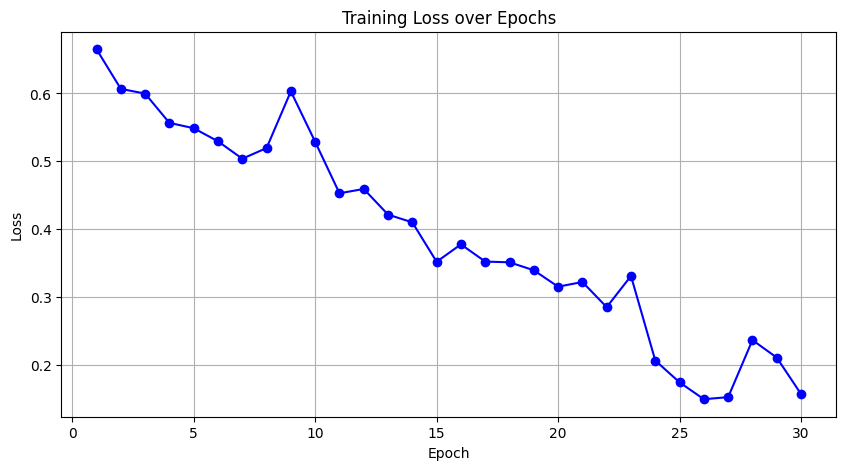

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss = []
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        print(inputs.shape)
        print(labels.shape)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    train_loss.append(running_loss/len(train_loader))
    

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Save the best model
        
        # Save the best model based on validation accuracy
        if epoch == 0 or (100 * correct / total) > best_accuracy:
            best_accuracy = 100 * correct / total
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, 'best_model.pth')

    print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
# Test the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    # Load the best model weights
    model.load_state_dict(torch.load('best_model.pth'))
    
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader)}, Accuracy: {100 * correct / total}%")

# Make a prediction
sample_input, sample_label = test_dataset[0]
sample_input = sample_input.unsqueeze(0)  # Add batch dimension
print(sample_input.shape)
model.eval()
with torch.no_grad():
    output = model(sample_input)
    # Print prediction for each sample in test data
    for i in range(len(test_dataset)):
        sample_input, sample_label = test_dataset[i]
        sample_input = sample_input.unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            output = model(sample_input)
            _, predicted_label = torch.max(output, 1)
        print(f"Sample {i}: True Label: {sample_label}, Predicted Label: {predicted_label.item()}")


C:\Users\anton\AppData\Local\Temp\ipykernel_22356\2631321726.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.34229661524295807, Accuracy: 89.0%
torch.Size([1, 4, 21, 21])
Sample 0: True Label: 0, Predicted Label: 0
Sample 1: True Label: 0, Predicted Label: 1
Sample 2: True Label: 1, Predicted Label: 1
Sample 3: True Label: 0, Predicted Label: 0
Sample 4: True Label: 0, Predicted Label: 0
Sample 5: True Label: 0, Predicted Label: 0
Sample 6: True Label: 0, Predicted Label: 0
Sample 7: True Label: 0, Predicted Label: 0
Sample 8: True Label: 0, Predicted Label: 0
Sample 9: True Label: 1, Predicted Label: 0
Sample 10: True Label: 0, Predicted Label: 0
Sample 11: True Label: 0, Predicted Label: 0
Sample 12: True Label: 0, Predicted Label: 0
Sample 13: True Label: 0, Predicted Label: 0
Sample 14: True Label: 0, Predicted Label: 0
Sample 15: True Label: 0, Predicted Label: 0
Sample 16: True Label: 0, Predicted Label: 0
Sample 17: True Label: 0, Predicted Label: 0
Sample 18: True Label: 1, Predicted Label: 1
Sample 19: True Label: 0, Predicted Label: 0
Sample 20: True Label: 0, Predicted

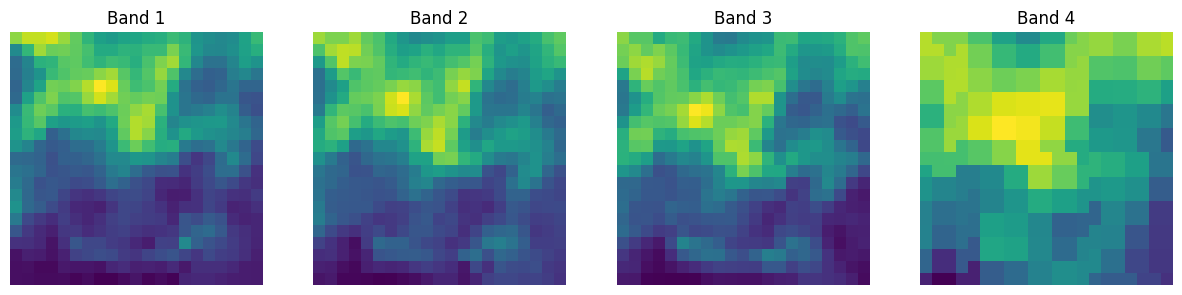

In [ ]:
# Get the first training sample
first_train_sample = train_features[0]

# Plot the bands as subplots
fig, axes = plt.subplots(1, first_train_sample.shape[-1], figsize=(15, 5))
for i in range(first_train_sample.shape[-1]):
    ax = axes[i]
    ax.imshow(first_train_sample[:, :, i], cmap='viridis')
    ax.set_title(f'Band {i+1}')
    ax.axis('off')

plt.show()

## References

1. [PyTorch CIFAR-10 Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
